In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import rlds
from PIL import Image
import numpy as np
from tf_agents.policies import py_tf_eager_policy
import tf_agents
from tf_agents.trajectories import time_step as ts
from IPython import display
from collections import defaultdict
import os
from absl import logging
import matplotlib.pyplot as plt
import pandas as pd
import re
import seaborn as sns

def as_gif(images):
  # Render the images as the gif:
  images[0].save('/tmp/temp.gif', save_all=True, append_images=images[1:], duration=1000, loop=0)
  gif_bytes = open('/tmp/temp.gif','rb').read()
  return gif_bytes


2023-10-26 23:24:44.502565: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-26 23:24:45.068012: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-26 23:24:45.070387: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-26 23:24:46.747144: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/qyb/anaconda3/envs/rt-x/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
use_module_path = "/home/qyb/Desktop/rt-x/universal-sentence-encoder_4/"
use_model = tf.keras.models.load_model(use_module_path)
print ("module %s loaded" % use_module_path)
def embed(input):
  return use_model(input)

module /home/qyb/Desktop/rt-x/universal-sentence-encoder_4/ loaded


In [3]:
# Load TF model checkpoint
# Replace saved_model_path with path to the parent folder of
# the folder rt_1_x_tf_trained_for_002272480_step.
saved_model_path = 'rt_1_x_tf_trained_for_002272480_step'

tfa_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    model_path=saved_model_path,
    load_specs_from_pbtxt=True,
    use_tf_function=True)

: 

In [ ]:
# Perform one step of inference using dummy input

# Obtain a dummy observation, where the features are all 0
observation = tf_agents.specs.zero_spec_nest(tf_agents.specs.from_spec(tfa_policy.time_step_spec.observation))

# Construct a tf_agents time_step from the dummy observation
tfa_time_step = ts.transition(observation, reward=np.zeros((), dtype=np.float32))

# Initialize the state of the policy
policy_state = tfa_policy.get_initial_state(batch_size=1)

# Run inference using the policy
action = tfa_policy.action(tfa_time_step, policy_state)

In [ ]:
def resize(image):
  image = tf.image.resize_with_pad(image, target_width=320, target_height=256)
  image = tf.cast(image, tf.uint8)
  return image

def terminate_bool_to_act(terminate_episode: tf.Tensor) -> tf.Tensor:
  return tf.cond(
      terminate_episode == tf.constant(1.0),
      lambda: tf.constant([1, 0, 0], dtype=tf.int32),
      lambda: tf.constant([0, 1, 0], dtype=tf.int32),
  )

def rescale_action_with_bound(
    actions: tf.Tensor,
    low: float,
    high: float,
    safety_margin: float = 0,
    post_scaling_max: float = 1.0,
    post_scaling_min: float = -1.0,
) -> tf.Tensor:
  """Formula taken from https://stats.stackexchange.com/questions/281162/scale-a-number-between-a-range."""
  resc_actions = (actions - low) / (high - low) * (
      post_scaling_max - post_scaling_min
  ) + post_scaling_min
  return tf.clip_by_value(
      resc_actions,
      post_scaling_min + safety_margin,
      post_scaling_max - safety_margin,
  )

def rescale_action(action):
  """Rescales action."""

  action['world_vector'] = rescale_action_with_bound(
      action['world_vector'],
      low=-0.05,
      high=0.05,
      safety_margin=0.01,
      post_scaling_max=1.75,
      post_scaling_min=-1.75,
  )
  action['rotation_delta'] = rescale_action_with_bound(
      action['rotation_delta'],
      low=-0.25,
      high=0.25,
      safety_margin=0.01,
      post_scaling_max=1.4,
      post_scaling_min=-1.4,
  )

  return action

def to_model_action(from_step):
  """Convert dataset action to model action. This function is specific for the Bridge dataset."""

  model_action = {}

  model_action['world_vector'] = from_step['action']['world_vector']
  print("terminate_episode",from_step['action']['terminate_episode'])
  # model_action['terminate_episode'] = terminate_bool_to_act(
  #     from_step['action']['terminate_episode']
  # )
  model_action['terminate_episode'] = from_step['action']['terminate_episode']

  model_action['rotation_delta'] = from_step['action']['rotation_delta']

  # open_gripper = from_step['action']['open_gripper']

  # possible_values = tf.constant([True, False], dtype=tf.bool)
  # eq = tf.equal(possible_values, open_gripper)

  # assert_op = tf.Assert(tf.reduce_any(eq), [open_gripper])

  # with tf.control_dependencies([assert_op]):
  #   model_action['gripper_closedness_action'] = tf.cond(
  #       # for open_gripper in bridge dataset,
  #       # 0 is fully closed and 1 is fully open


  #       # open_gripper,



  #       # for Fractal data,
  #       # gripper_closedness_action = -1 means opening the gripper and
  #       # gripper_closedness_action = 1 means closing the gripper.
  #       lambda: tf.constant([-1.0], dtype=tf.float32),
  #       lambda: tf.constant([1.0], dtype=tf.float32),
  #   )
  model_action['gripper_closedness_action'] = from_step['action']['gripper_closedness_action']

  model_action = rescale_action(model_action)

  return model_action

def to_model_action(action):
  """Convert dataset action to model action. This function is specific for the Bridge dataset."""

  model_action = {}

  model_action['world_vector'] = action['world_vector']
  
  model_action['terminate_episode'] = action['terminate_episode']

  model_action['rotation_delta'] = action['rotation_delta']

  model_action['gripper_closedness_action'] =action['gripper_closedness_action']

  model_action = rescale_action(model_action)

  return model_action

In [ ]:
# 设置图片文件夹路径
image_folder_path = "/home/qyb/Desktop/rt-x/own_data"

# 打开图片文件夹，列出所有图片文件
images = os.listdir(image_folder_path)

# 初始化空的numpy数组，用于存放所有图片
images_array = []

# 对于每一个图片文件，打开图片，转化为numpy数组，并添加到images_array中
for image in images:
    # 打开图片
    img = Image.open(os.path.join(image_folder_path, image))
    # 将图片转化为numpy数组
    img_array = np.array(img)
    # 将numpy数组添加到images_array中
    images_array.append(img_array)
images_array=np.array(images_array)

In [ ]:
sentence = "Grab that red square."
messages = sentence

# Reduce logging output.
logging.set_verbosity(logging.ERROR)

message_embeddings = embed(messages)

for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
  print("Message: {}".format(messages[i]))
  print("Embedding size: {}".format(len(message_embedding)))
  message_embedding_snippet = ", ".join(
      (str(x) for x in message_embedding[:3]))
  print("Embedding: [{}, ...]\n".format(message_embedding_snippet))

In [ ]:
images_array
images_array.shape

(2, 1707, 1280, 3)

In [ ]:
images_array

array([[[[152, 154, 141],
         [152, 154, 141],
         [152, 154, 141],
         ...,
         [ 94, 101,  94],
         [ 94, 101,  94],
         [ 94, 101,  94]],

        [[152, 154, 141],
         [152, 154, 141],
         [152, 154, 141],
         ...,
         [ 94, 101,  94],
         [ 94, 101,  94],
         [ 94, 101,  94]],

        [[152, 154, 141],
         [152, 154, 141],
         [152, 154, 141],
         ...,
         [ 94, 101,  94],
         [ 94, 101,  94],
         [ 94, 101,  94]],

        ...,

        [[229, 230, 225],
         [230, 231, 226],
         [230, 231, 226],
         ...,
         [ 16,  17,  19],
         [ 17,  18,  20],
         [ 18,  19,  21]],

        [[229, 230, 225],
         [230, 231, 226],
         [230, 231, 226],
         ...,
         [ 21,  22,  24],
         [ 22,  23,  25],
         [ 22,  23,  25]],

        [[229, 230, 225],
         [230, 231, 226],
         [230, 231, 226],
         ...,
         [ 24,  25,  27],
        

In [ ]:
# %%time


policy_state = tfa_policy.get_initial_state(batch_size=1)
gt_actions = []
predicted_actions = []
images = []
observations=[]
observation['natural_language_embedding'] =  message_embeddings
for image in images_array:

  image = resize(image)

  images.append(image)
  observation['image'] = image
  #policy_state = tfa_policy.get_initial_state(batch_size=1)
  #policy_state['seq_idx'] = np.zeros((1, 1, 1, 1, 1), dtype=np.int32)
  tfa_time_step = ts.transition(observation, reward=np.zeros((), dtype=np.float32))
  #print(dir(policy_state))
  policy_step = tfa_policy.action(tfa_time_step, policy_state)
  action = policy_step.action
  policy_state = policy_step.state
  predicted_actions.append(action)
  gt_actions.append(to_model_action(action))
  

In [ ]:
len(gt_actions)

2

In [ ]:
image=np.array(images[0])
print(image)
# cv2.imshow("img",image)

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [ ]:
x = tf.constant(b'Hello World!')
print(x)
# 转换为普通字符串并打印
print(x.numpy().decode())

tf.Tensor(b'Hello World!', shape=(), dtype=string)
Hello World!


In [ ]:
print(predicted_actions[1]["world_vector"] )

[-0.00391388 -0.00391388 -0.00391388]


In [ ]:
action_name_to_values_over_time = defaultdict(list)
predicted_action_name_to_values_over_time = defaultdict(list)
figure_layout = ['terminate_episode_0', 'terminate_episode_1',
        'terminate_episode_2', 'world_vector_0', 'world_vector_1',
        'world_vector_2', 'rotation_delta_0', 'rotation_delta_1',
        'rotation_delta_2', 'gripper_closedness_action_0']
action_order = ['terminate_episode', 'world_vector', 'rotation_delta', 'gripper_closedness_action']

for i, action in enumerate(gt_actions):

  for action_name in action_order:

    for action_sub_dimension in range(action[action_name].shape[0]):

      # print(action_name, action_sub_dimension)
      title = f'{action_name}_{action_sub_dimension}'

      action_name_to_values_over_time[title].append(action[action_name][action_sub_dimension])
      predicted_action_name_to_values_over_time[title].append(predicted_actions[i][action_name][action_sub_dimension])

In [ ]:
figure_layout = [
    ['image'] * len(figure_layout),
    figure_layout
]


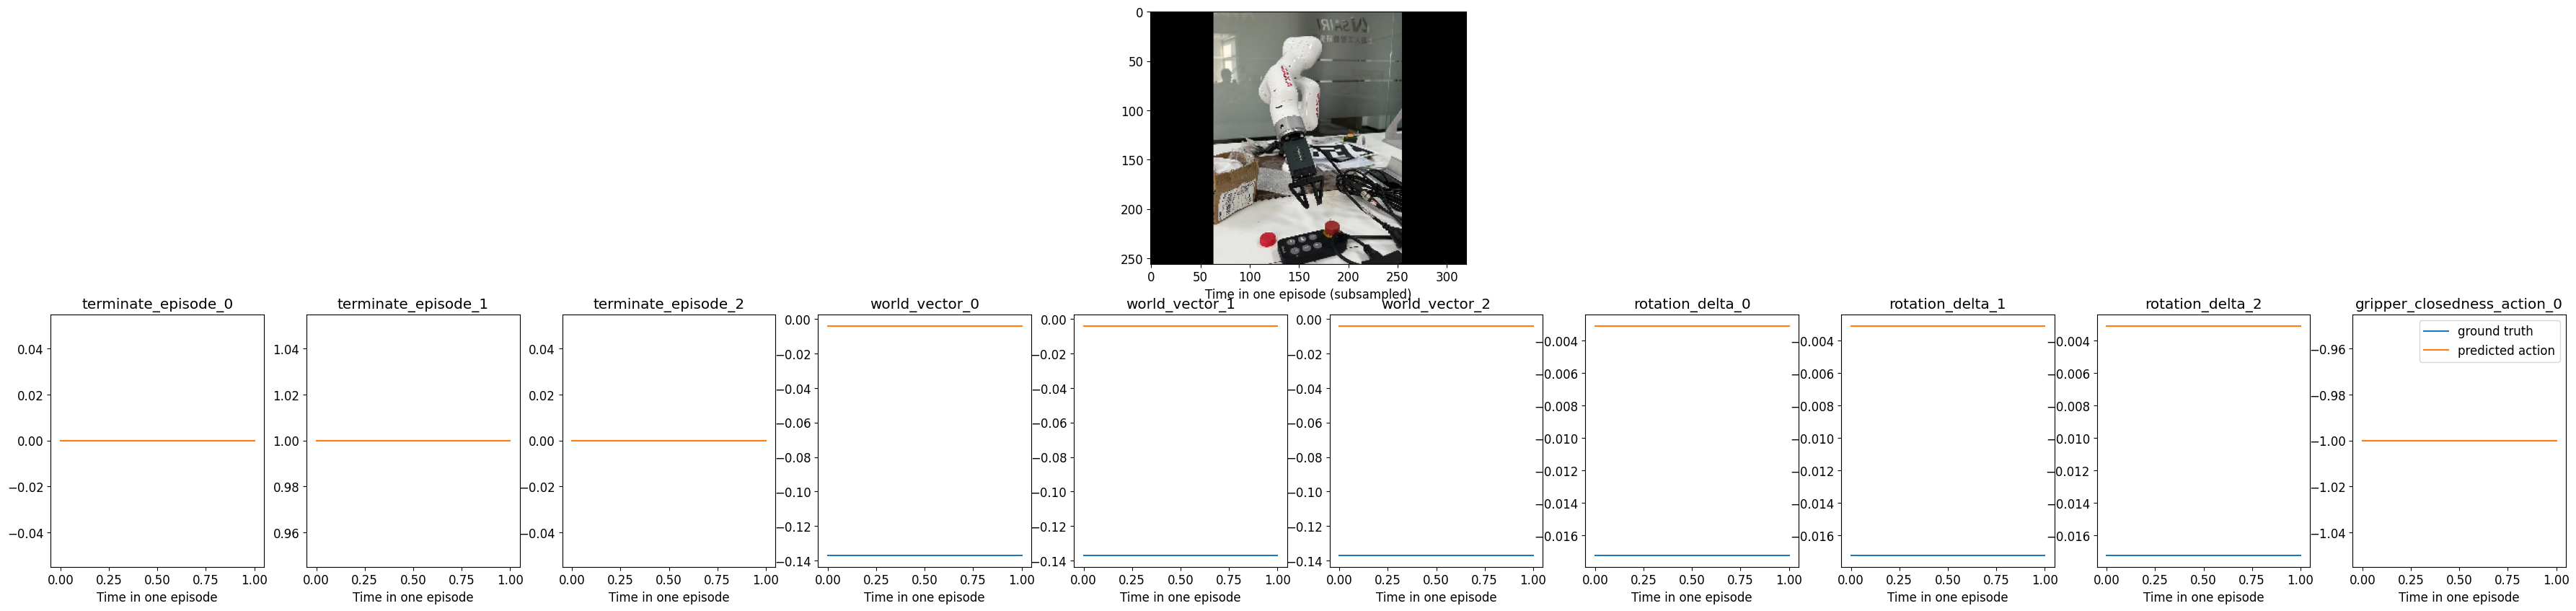

In [ ]:
plt.rcParams.update({'font.size': 12})

stacked = tf.concat(tf.unstack(images[::3], axis=0), 1)

fig, axs = plt.subplot_mosaic(figure_layout)
fig.set_size_inches([45, 10])

for i, (k, v) in enumerate(action_name_to_values_over_time.items()):

  axs[k].plot(v, label='ground truth')
  axs[k].plot(predicted_action_name_to_values_over_time[k], label='predicted action')
  axs[k].set_title(k)
  axs[k].set_xlabel('Time in one episode')

axs['image'].imshow(stacked.numpy())
axs['image'].set_xlabel('Time in one episode (subsampled)')

plt.legend()
